### You can use this notebook to:
 1. Load the models and double check that they are not duplicates
 2. Play the models against each other
 3. Play the models against Stockfish
 3. Play the models against a human


#### Imports

In [1]:
import os
import sys
src_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'src'))
sys.path.append(src_path)
import chess
import json
import logging
import time
from tensorflow.keras.models import Model
import chess.svg
from IPython.display import SVG, display, clear_output
from chess_zero.config import Config, PlayWithHumanConfig
from chess_zero.agent.model_chess import ChessModel
from chess_zero.agent.player_chess import ChessPlayer
import numpy as np
from chess_zero.env.chess_env import ChessEnv
from chess_zero.agent.model_chess import ChessModel
from chess_zero.lib.model_helper import load_best_model_weight

2024-09-27 16:59:59.306219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 16:59:59.494723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 16:59:59.517627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 16:59:59.672867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 17:00:01.027306: W tensorflow/compiler/tf2

#### Load the models and double check that they are not duplicates

In [2]:
# set the model paths to compare
# Paths for model A and B
model_a_path = '/home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_A'
model_b_path = '/home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_B'

# change this so it reads the file from the model_a_path and model_b_path and loads the mode

In [4]:
# Configure logging
logging.basicConfig(filename='chess_game.log', level=logging.DEBUG, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

config = Config()

def load_specific_model(model, config_path, weight_path):
    """
    Load a specific model from given paths
    """
    if os.path.exists(config_path) and os.path.exists(weight_path):
        with open(config_path, "rt") as f:
            model.model = Model.from_config(json.load(f))
        # print(f"Model summary for {weight_path}:")
        try:
            # Try to load the weights file
            model.model.load_weights(weight_path)
            logging.info(f"Weights loaded successfully from {weight_path}")
            return True
        except Exception as e:
            logging.error(f"Error loading weights: {str(e)}")
            return False
    else:
        logging.error(f"Model files not found at {config_path} or {weight_path}")
        return False
    

def find_model_files(model_path):
    """Find the config and weight files in the given model path."""
    config_file = None
    weight_file = None
    for file in os.listdir(model_path):
        if file.endswith('.json'):
            config_file = os.path.join(model_path, file)
        elif file.endswith('.h5'):
            weight_file = os.path.join(model_path, file)
    return config_file, weight_file

# Find the model files
model_a_config, model_a_weights = find_model_files(model_a_path)
model_b_config, model_b_weights = find_model_files(model_b_path)

# Create model instances
model_a = ChessModel(config)
model_b = ChessModel(config)

# Load the specific models
load_specific_model(model_a, model_a_config, model_a_weights)
load_specific_model(model_b, model_b_config, model_b_weights)

# Print the locations of the loaded models
logging.info("Model A config: %s", model_a_config)
logging.info("Model A weights: %s", model_a_weights)
logging.info("Model B config: %s", model_b_config)
logging.info("Model B weights: %s", model_b_weights)


def models_are_equal(model_a, model_b):
    weights_a = model_a.model.get_weights()
    weights_b = model_b.model.get_weights()
    
    if len(weights_a) != len(weights_b):
        return False
    
    return all(np.array_equal(w_a, w_b) for w_a, w_b in zip(weights_a, weights_b))

if models_are_equal(model_a, model_b):
    logging.info("The models are duplicates")
else:
    logging.info("The models are not duplicates")


##### Game functions


In [6]:
def setup_players(model_a, model_b, config):
    pipes_a = model_a.get_pipes(config.play.search_threads)
    pipes_b = model_b.get_pipes(config.play.search_threads)
    player_a = ChessPlayer(config, pipes=pipes_a)
    player_b = ChessPlayer(config, pipes=pipes_b)
    return player_a, player_b

def display_board(board):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=800)))

import signal

class TimeoutException(Exception): pass

def timeout_handler(signum, frame):
    raise TimeoutException("Action timed out")
import logging
import time
from collections import Counter

def compare_models(model_a, model_b, config, num_games):
    results = Counter()
    player_a = ChessPlayer(config, pipes=model_a.get_pipes(config.play.search_threads))
    player_b = ChessPlayer(config, pipes=model_b.get_pipes(config.play.search_threads))
    
    for game in range(num_games):
        logging.info(f"\nGame {game + 1}")
        if game % 2 == 0:
            white, black = player_a, player_b
            white_name, black_name = "Model A", "Model B"
        else:
            white, black = player_b, player_a
            white_name, black_name = "Model B", "Model A"
        
        env = ChessEnv()
        logging.info(f"Starting game {game + 1} with {white_name} as white and {black_name} as black")
        try:
            result = play_game(white, black, env, white_name, black_name)
            results[result] += 1
            logging.info(f"Game {game + 1} result: {result}")
        except Exception as e:
            logging.error(f"Error in game {game + 1}: {str(e)}")
            results['error'] += 1
        
        # Add a small delay between games
        time.sleep(2)
    
    return results

def play_game(player_white, player_black, env, white_name, black_name):
    env.reset()
    done = False
    move_count = 0
    
    while not done:
        display_board(env.board)
        logging.info(f"Board state before move {move_count + 1}:\n{env.board}")
        
        if env.white_to_move:
            current_player = player_white
            player_name = white_name
        else:
            current_player = player_black
            player_name = black_name
        
        logging.info(f"{player_name} is thinking...")
        
        try:
            action = current_player.action(env)
            logging.info(f"{player_name} action: {action}")
            
            if isinstance(action, str):
                move = chess.Move.from_uci(action)
            elif isinstance(action, chess.Move):
                move = action
            else:
                raise ValueError(f"Invalid move type from {player_name}: {type(action)}")
            
            if move not in env.board.legal_moves:
                raise ValueError(f"Illegal move by {player_name}: {move}")
            
            env.board.push(move)
            move_count += 1
            
            logging.info(f"Move {move_count}: {player_name} plays {move}")
            
        except Exception as e:
            logging.error(f"Error during {player_name}'s move: {str(e)}")
            return 1 if env.white_to_move else -1  # The other player wins due to error
        
        # Check for game-ending conditions
        if env.board.is_checkmate():
            display_board(env.board)
            logging.info(f"Checkmate! {player_name} wins.")
            return 1 if not env.white_to_move else -1
        elif env.board.is_stalemate() or env.board.is_insufficient_material() or env.board.is_fifty_moves() or env.board.is_repetition():
            display_board(env.board)
            logging.info("Game is a draw by rule")
            return 0
        elif move_count > 250:
            logging.info("Game exceeded 250 moves, ending in a draw.")
            return 0
        
        # time.sleep(1)  # Add a delay to make it easier to follow the game
    
    display_board(env.board)
    return env.winner



#### Showtime

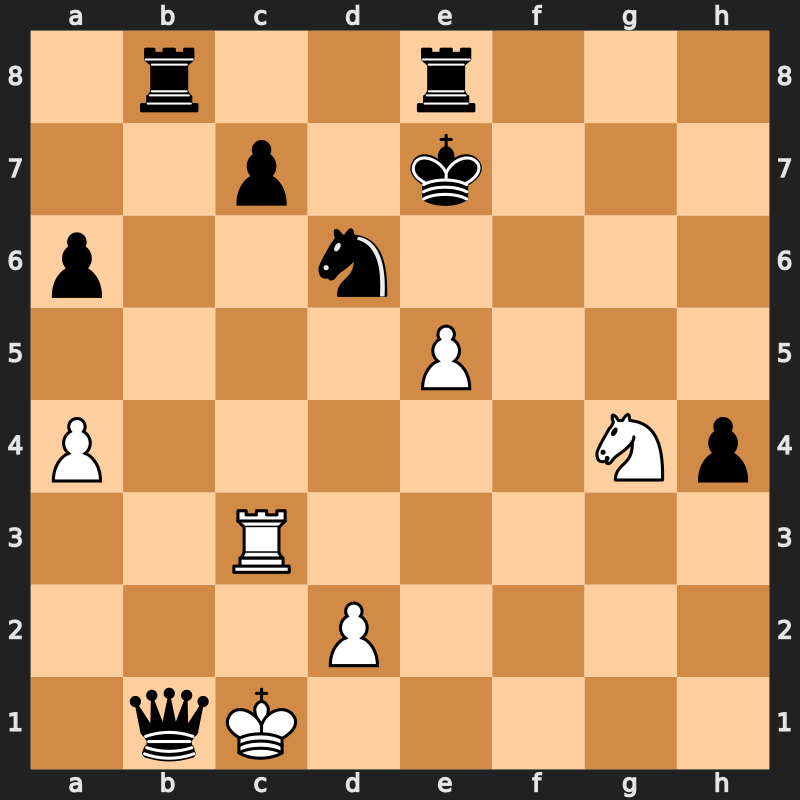

In [7]:
# Usage
num_games = 2
config = Config()
results = compare_models(model_a, model_b, config, num_games=num_games)

logging.info("\nFinal Results:")
logging.info(f"Model A wins: {results['Model A_win']}")
logging.info(f"Model B wins: {results['Model B_win']}")
logging.info(f"Draws: {results['draw']}")
logging.info(f"Errors: {results['error']}")


####  Stockfish vs AlphaZero

In [ ]:
from stockfish import Stockfish
import chess
import chess.svg
from IPython.display import SVG, display, clear_output
import time


def setup_player(model, config):
    pipes = model.get_pipes(config.play.search_threads)
    player = ChessPlayer(config, pipes=pipes)
    return player

def get_stockfish_move(stockfish, time_limit=1.0):
    best_move = stockfish.get_top_moves(3)[2]['Move']
    print(best_move)
    # best_move = stockfish.get_best_move_time(int(time_limit * 1000))
    return best_move

def display_board(board):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=400)))

def play_game(alpha_zero_player, stockfish, env, time_limit=1.0):
    env.reset()
    done = False
    move_count = 0
    while not done:
        display_board(env.board)
        if env.white_to_move:
            print("AlphaZero is thinking...")
            action = alpha_zero_player.action(env)
            player = "AlphaZero"
        else:
            print("Stockfish is thinking...")
            stockfish.set_fen_position(env.board.fen())
            action = get_stockfish_move(stockfish, time_limit)
            player = "Stockfish"
        print(f"Move {move_count + 1}: {player} plays {action}")
        try:
            env.step(action)
        except ValueError as e:
            print(f"Invalid move: {action}. Error: {str(e)}")
            return (1 if player == "Stockfish" else -1), move_count  # The other player wins due to invalid move
        move_count += 1
        
        # Check for game-ending conditions
        if env.board.is_checkmate():
            display_board(env.board)
            return (-1 if env.white_to_move else 1), move_count  # The player who just moved wins
        elif env.board.is_stalemate() or env.board.is_insufficient_material() or env.board.is_fifty_moves() or env.board.is_repetition():
            print("Game is a draw by rule")
            time.sleep(5)
            display_board(env.board)
            return 0, move_count  # Draw
        elif move_count > 250:
            print("Game exceeded 250 moves, ending in a draw.")
            return 0, move_count
        
        time.sleep(1)  # Add a delay to make it easier to follow the game
    
    # This should not be reached, but just in case
    display_board(env.board)
    return env.winner, move_count

def play_alphazero_vs_stockfish(model_a, config, num_games=1, time_limit=1.0):
    alpha_zero_player = setup_player(model_a, config)
    env = ChessEnv()
    results = {'alpha_zero_wins': 0, 'stockfish_wins': 0, 'draws': 0, 'total_moves': 0}
    
    stockfish = Stockfish(path="/usr/games/stockfish")
    
    for game in range(num_games):
        print(f"\nGame {game + 1}")
        try:
            if game % 2 == 0:
                winner, moves = play_game(alpha_zero_player, stockfish, env, time_limit)
            else:
                winner, moves = play_game(stockfish, alpha_zero_player, env, time_limit)
                winner = -winner  # Invert the winner since AlphaZero is playing black
            
            results['total_moves'] += moves
            if winner == 1:
                results['alpha_zero_wins'] += 1
                print(f"AlphaZero wins by checkmate in {moves} moves!")
            elif winner == -1:
                results['stockfish_wins'] += 1
                print(f"Stockfish wins by checkmate in {moves} moves!")
            else:
                results['draws'] += 1
                print(f"It's a draw after {moves} moves!")
            print(f"Final position: {env.board.fen()}")
            time.sleep(5)
        except Exception as e:
            print(f"Error in game {game + 1}: {str(e)}")
            break
    
    return results

# Run the game
config = Config()
results = play_alphazero_vs_stockfish(model_a, config, num_games=1, time_limit=1.0)

print(f"\nFinal Results:")
print(f"AlphaZero wins: {results['alpha_zero_wins']}")
print(f"Stockfish wins: {results['stockfish_wins']}")
print(f"Draws: {results['draws']}")
print(f"Total moves: {results['total_moves']}")
# print(f"Average moves per game: {results['total_moves'] / (results['alpha_zero_wins'] + results['stockfish_wins'] + results['draws']):.2f}")

#### Play the model


In [ ]:
# Play the model against a human
def get_player(config):
    model = ChessModel(config)
    if not load_best_model_weight(model):
        raise RuntimeError("Best model not found!")
    return ChessPlayer(config, model.get_pipes(config.play.search_threads))

def display_board(board):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=400)))

def play_game():
    default_config = Config()
    PlayWithHumanConfig().update_play_config(default_config.play)
    ai_player = get_player(default_config)
    env = ChessEnv().reset()

    while not env.done:
        display_board(env.board)
        
        if env.board.turn == chess.WHITE:  # Human plays as White
            while True:
                try:
                    move = input("Enter your move (e.g., e2e4): ")
                    env.step(move)  # Pass the string directly
                    break
                except ValueError:
                    print("Invalid move. Try again.")
        else:  # AI plays as Black
            action = ai_player.action(env, False)
            print(f"AI move: {action}")
            env.step(action)
    
    display_board(env.board)
    print("Game Over")
    print(f"Result: {env.board.result()}")

# Run the game`
play_game()